<a href="https://colab.research.google.com/github/wlady777/Coursera_Capstone/blob/main/Notebook_CapstoneProject_The_Battle_Of_The_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods: Open a Brazilian Restaurant in Miami

## by Anderson Braz



*   Read the report of this project.  
*   Read the post of this project.
*   Below you have all the code and techniques used.



# Step 01 - Install and Import Libraries Necessary

In [ ]:
## My Installs
!pip install BeautifulSoup4
!pip install lxml
!pip install geocoder
!pip install seaborn
!pip install wordcloud
!pip install sklearn --upgrade
!pip install folium --upgrade

## My Imports
import pandas as pd
from bs4 import BeautifulSoup
import requests ## Used to make requisitions
import geocoder ## Used to capture latitude e longitude from location
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import folium

import warnings
warnings.filterwarnings('ignore')

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)
Requirement already up-to-date: folium in /usr/local/lib/python3.6/dist-packages (0.12.1)


# Step 02 - Preparation of Parameters and Useful Functions

In [ ]:
# PARAMETERS - API FOURSQUARE

CLIENT_ID = 'XHF5F4ELEBCHPZWQELVEFKYUCRORBHEQKK3XO43KOC2U0Z2N'
CLIENT_SECRET = 'XSL4HY52S3DOWZQ51WABH3M5QD5GAYP1A3PFNAGIGJNRYICD'
VERSION = '20180605'

# PARAMETERS - INIT FOLIUM

LOCATION_SPEC = '{}, FLORIDA, Miami City, EUA'
LATITUDE_MIAMI = 25.7825453
LONGITUDE_MIAMI = -80.2994988

In [ ]:
## Function capture Latitude and Longitue from Neighborhood

def get_latlng (neighborhood):
  
  lat_lng_coords = None 
  while (lat_lng_coords is None): 
      g = geocoder.arcgis (LOCATION_SPEC.format (neighborhood)) 
      lat_lng_coords = g.latlng 
  return lat_lng_coords

## Function capture details venue with API Foursquare

def get_venues(lat,lng):
    
  #set variables
  radius = 3000
  LIMIT = 100
  
  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius, 
          LIMIT)
  
  # get all the data
  results = requests.get(url).json()
  venue_data = results["response"]['groups'][0]['items']
  venue_details = []
  for row in venue_data:
      try:
          venue_id = row['venue']['id']
          venue_name = row['venue']['name']
          venue_category = row['venue']['categories'][0]['name']
          venue_origin = row['venue']['categories'][0]['shortName']
          venue_latitude = row['venue']['location']['lat']
          venue_longitude = row['venue']['location']['lng']
          venue_details.append([venue_id, venue_name, venue_category, venue_origin, venue_latitude, venue_longitude])
      except KeyError:
          pass
      
  column_names=['ID', 'Name', 'Category', 'Origin', 'Latitude', 'Longitude']
  df = pd.DataFrame(venue_details, columns = column_names)
  print("done!")
  return df

def get_info(id):

  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&v={}&client_secret={}'.format(
          id,
          CLIENT_ID, 
          VERSION, 
          CLIENT_SECRET)

  # get all the data
  result = requests.get(url).json()
  venue_info = result['response']

  return venue_info
  
def return_most_common_venues(row, num_top_venues):

  row_categories = row.iloc[1:]
  row_categories_sorted = row_categories.sort_values(ascending = False)

  return row_categories_sorted.index.values[0:num_top_venues]

# Step 03 - Scraping Source Data 

In [ ]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami')
soup = BeautifulSoup(response.content, 'lxml')
table = soup.find_all('table')[0]
data = pd.read_html(str(table))

source_table = pd.DataFrame(data[0])
source_table


,Neighborhood,Demonym,Population2010,Population/Km²,Sub-neighborhoods,Coordinates
0,Allapattah,NaN,54289,4401,NaN,25.815-80.224
1,Arts & Entertainment District,NaN,11033,7948,NaN,25.799-80.190
2,Brickell,Brickellite,31759,14541,West Brickell,25.758-80.193
3,Buena Vista,NaN,9058,3540,Buena Vista East Historic District and Design ...,25.813-80.192
4,Coconut Grove,Grovite,20076,3091,"Center Grove, Northeast Coconut Grove, Southwe...",25.712-80.257
5,Coral Way,NaN,35062,4496,"Coral Gate, Golden Pines, Shenandoah, Historic...",25.750-80.283
6,Design District,NaN,3573,3623,NaN,25.813-80.193
7,Downtown,Downtowner,"71,000 (13,635 CBD only)",10613,"Brickell, Central Business District (CBD), Dow...",25.774-80.193
8,Edgewater,NaN,15005,6675,NaN,25.802-80.190
9,Flagami,NaN,50834,5665,"Alameda, Grapeland Heights, and Fairlawn",25.762-80.316


# Step 04 - Cleaning and Preparing Datas

**IMPORTANT:** It is in this stage where we will most work and spend time.

## 04.1 - Isolating only names in a list

In [ ]:
unwanted = {'Downtown', 'Edgewater', 'Health District', 'Liberty City', 'Miami'} ## Remove Possible Trash 
list_neighborhood = source_table['Neighborhood']
list_neighborhood = [e for e in list_neighborhood if e not in unwanted]

list_neighborhood

['Allapattah',
 'Arts & Entertainment District',
 'Brickell',
 'Buena Vista',
 'Coconut Grove',
 'Coral Way',
 'Design District',
 'Flagami',
 'Grapeland Heights',
 'Little Haiti',
 'Little Havana',
 'Lummus Park',
 'Midtown',
 'Overtown',
 'Park West',
 'The Roads',
 'Upper Eastside',
 'Venetian Islands',
 'Virginia Key',
 'West Flagler',
 'Wynwood']



## 04.2 - Preparing, Cleaning and Sorting with DataFrame (Neighborhood, Latitude, Longitude and Details)



In [ ]:
columns_names = ['Neighborhood', 'Latitude', 'Longitude']
neighborhood_miami = pd.DataFrame(columns = columns_names)

for row in list_neighborhood:
  Neighborhood = row
  coords = get_latlng(Neighborhood)
  neighborhood_miami = neighborhood_miami.append({'Neighborhood':Neighborhood, 'Latitude':coords[0], 'Longitude':coords[1]}, ignore_index = True)

neighborhood_miami

,Neighborhood,Latitude,Longitude
0,Allapattah,25.814800,-80.224130
1,Arts & Entertainment District,25.774810,-80.197730
2,Brickell,25.774810,-80.197730
3,Buena Vista,25.817840,-80.192570
4,Coconut Grove,25.732330,-80.254140
5,Coral Way,25.742701,-80.440205
6,Design District,25.812780,-80.192110
7,Flagami,25.762710,-80.315870
8,Grapeland Heights,25.788883,-80.253423
9,Little Haiti,25.828640,-80.198330




## 04.3 - Searching for Restaurants in The Areas 



In [ ]:
target = 'Restaurant'
columns_names = ['Neighborhood', 'ID', 'Name', 'Latitude', 'Longitude']
restaurants_miami = pd.DataFrame(columns = columns_names)
count=1

for row in neighborhood_miami.values.tolist():
  Neighborhood, Latitude, Longitude = row
  venues = get_venues(Latitude, Longitude)
  ##restaurants = venues[venues['Category'] == target]
  restaurants = venues[venues['Category'].str.contains(target)]
  print('(',count,'/',len(neighborhood_miami),')', 
        target + ' in ' + 
        Neighborhood + ': ' + 
        str(len(restaurants)))
  
  for detail in restaurants.values.tolist():
    id, name, category, food, lat, lng = detail
    restaurants_miami = restaurants_miami.append({
        'Neighborhood':Neighborhood, 'ID':id, 'Name':name, 
        'Category':category, 'Food':food, 
        'Latitude':lat, 'Longitude':lng}, ignore_index = True)
  count += 1

done!
( 1 / 21 ) Restaurant in Allapattah: 25
done!
( 2 / 21 ) Restaurant in Arts & Entertainment District: 39
done!
( 3 / 21 ) Restaurant in Brickell: 39
done!
( 4 / 21 ) Restaurant in Buena Vista: 30
done!
( 5 / 21 ) Restaurant in Coconut Grove: 34
done!
( 6 / 21 ) Restaurant in Coral Way: 22
done!
( 7 / 21 ) Restaurant in Design District: 28
done!
( 8 / 21 ) Restaurant in Flagami: 33
done!
( 9 / 21 ) Restaurant in Grapeland Heights: 29
done!
( 10 / 21 ) Restaurant in Little Haiti: 33
done!
( 11 / 21 ) Restaurant in Little Havana: 51
done!
( 12 / 21 ) Restaurant in Lummus Park: 38
done!
( 13 / 21 ) Restaurant in Midtown: 27
done!
( 14 / 21 ) Restaurant in Overtown: 30
done!
( 15 / 21 ) Restaurant in Park West: 39
done!
( 16 / 21 ) Restaurant in The Roads: 42
done!
( 17 / 21 ) Restaurant in Upper Eastside: 38
done!
( 18 / 21 ) Restaurant in Venetian Islands: 23
done!
( 19 / 21 ) Restaurant in Virginia Key: 13
done!
( 20 / 21 ) Restaurant in West Flagler: 19
done!
( 21 / 21 ) Restauran



## 04.4 - Checking Datas - All Restaurants



In [ ]:
restaurants_miami = restaurants_miami.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_miami

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,Allapattah,4b80657df964a5207b6e30e3,Plaza Seafood Market,25.805638,-80.223992,Seafood Restaurant,Seafood
1,Allapattah,4e4e169ebd4101d0d7a1e826,Snappers Fish & Chicken,25.824110,-80.224870,Seafood Restaurant,Seafood
2,Allapattah,4b59e8fff964a5202ba028e3,Papo Llega y Pon,25.803466,-80.223886,Cuban Restaurant,Cuban
3,Allapattah,5b0dbd3b237dee002c0ad551,Love Life Cafe,25.801454,-80.203389,Vegetarian / Vegan Restaurant,Vegetarian / Vegan
4,Allapattah,56a93d4d498e2efdf0de09e5,KYU,25.800933,-80.200203,Asian Restaurant,Asian
...,...,...,...,...,...,...,...
376,West Flagler,5647b92b498ebb7b54eaeee5,Dr. Limon Ceviche Bar - FIU,25.760445,-80.367000,Peruvian Restaurant,Peruvian
377,West Flagler,4cfa691bfeec6dcbcaae3f36,El Centroamericano #2,25.766977,-80.368508,Latin American Restaurant,Latin American
378,West Flagler,4b5f3558f964a52066ad29e3,La Carreta,25.785594,-80.368177,Cuban Restaurant,Cuban
379,West Flagler,4b9d39f9f964a5203d9b36e3,Jardines De Confucio,25.775368,-80.368472,Chinese Restaurant,Chinese


## 04.5 - Show Map - All Restaurants

In [ ]:
MIAMI_COORDINATES = (LATITUDE_MIAMI, LONGITUDE_MIAMI)
map_miami = folium.Map(location = MIAMI_COORDINATES, zoom_start = 11)

locations = restaurants_miami[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for i in range(0, len(location_list)):

  point_name = restaurants_miami['Name'][i]
  point_yard = restaurants_miami['Neighborhood'][i]
  point_category = restaurants_miami['Category'][i]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'
  
  label = '{}'.format(point_detail)

  if (point_category == 'Brazilian Restaurant'):
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail, 
        icon = folium.Icon(color='red')).add_to(map_miami)
  else:
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail).add_to(map_miami)

folium.Circle([LATITUDE_MIAMI, LONGITUDE_MIAMI], radius = 20000).add_to(map_miami)
display(map_miami)

Number of point(s): 381


## 04.6 - Checking Datas - Only Brazilian Restaurant

In [ ]:
br_restaurants_miami = restaurants_miami[restaurants_miami['Category'].str.contains('Brazilian Restaurant')]
br_restaurants_miami = br_restaurants_miami.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
br_restaurants_miami

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,Arts & Entertainment District,514b7bb8e4b0476ac82afd55,Steak Brasil,25.772831,-80.192034,Brazilian Restaurant,Brazilian
1,Upper Eastside,4ae2706ef964a5204d8e21e3,Boteco Miami,25.847920,-80.177723,Brazilian Restaurant,Brazilian


## 04.7 - Show Map - Brazilian Restaurants

In [ ]:
map_miami_br = folium.Map(location = MIAMI_COORDINATES, zoom_start = 11)

locations = br_restaurants_miami[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for j in range(0, len(location_list)):

  point_name = br_restaurants_miami['Name'][j]
  point_yard = br_restaurants_miami['Neighborhood'][j]
  point_category = br_restaurants_miami['Category'][j]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'

  folium.Marker(
      location_list[j], 
      popup = point_detail, 
      tooltip = point_detail, 
      icon = folium.Icon(color='green')).add_to(map_miami_br)
  
folium.Circle([LATITUDE_MIAMI, LONGITUDE_MIAMI], radius = 20000).add_to(map_miami_br)
display(map_miami_br)

Number of point(s): 2


## 04.6 - Checking Datas - Categories Counter

In [ ]:
restaurants_category = restaurants_miami.groupby('Food').size().reset_index(name='Count')
restaurants_category = restaurants_category.sort_values(by='Count', ascending = False).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_category

,Food,Count
0,Italian,42
1,Latin American,38
2,Cuban,38
3,Restaurant,28
4,Seafood,28
5,Mexican,24
6,American,23
7,Spanish,14
8,Sushi,13
9,Fast Food,12


## 04.7 - Checking Datas - Categories Counter by Neighborhood

In [ ]:
restaurants_neighborhood = restaurants_miami.groupby(['Neighborhood', 'Food']).size().reset_index(name='Count')
restaurants_neighborhood = restaurants_neighborhood.sort_values(by='Food', ascending = False).reset_index(drop = True)
restaurants_neighborhood

,Neighborhood,Food,Count
0,West Flagler,Vietnamese,1
1,Coconut Grove,Vietnamese,1
2,Little Haiti,Vietnamese,1
3,Little Havana,Venezuelan,1
4,Little Haiti,Venezuelan,1
...,...,...,...
203,Overtown,American,1
204,Little Haiti,American,1
205,Coconut Grove,American,5
206,Buena Vista,American,1


## 04.7 - Summary

In [ ]:
 print('There are {} uniques categories.'.format(len(restaurants_miami['Category'].unique())))
 print('There are {} restaurants.'.format(len(restaurants_miami['ID'].unique())))
 print('There are {} restaurants brazilizan.'.format(len(br_restaurants_miami['ID'].unique())))

There are 36 uniques categories.
There are 381 restaurants.
There are 2 restaurants brazilizan.


# Step 05 - Analize


In [ ]:
# one hot encoding
neighborhood_onehot = pd.get_dummies(restaurants_miami[['Food']], prefix="", prefix_sep="")
neighborhood_onehot['Neighborhood'] = restaurants_miami['Neighborhood']
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]


neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped

,Neighborhood,American,Arepas,Argentinian,Asian,Brazilian,Caribbean,Chinese,Comfort Food,Cuban,Empanada,Fast Food,French,Greek,Indian,Italian,Japanese,Korean,Latin American,Mediterranean,Mexican,Middle Eastern,New American,Peruvian,Portuguese,Restaurant,Seafood,South American,Southern / Soul,Spanish,Sushi,Tapas,Tex-Mex,Thai,Vegetarian / Vegan,Venezuelan,Vietnamese
0,Allapattah,0.040000,0.000000,0.000000,0.080000,0.000000,0.080000,0.040000,0.04,0.120000,0.000000,0.120000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.080000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.120000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000
1,Arts & Entertainment District,0.102564,0.000000,0.051282,0.051282,0.025641,0.000000,0.025641,0.00,0.000000,0.000000,0.000000,0.025641,0.025641,0.000000,0.153846,0.051282,0.000000,0.025641,0.025641,0.051282,0.000000,0.000000,0.051282,0.000000,0.102564,0.179487,0.000000,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000
2,Buena Vista,0.038462,0.038462,0.038462,0.038462,0.000000,0.000000,0.038462,0.00,0.038462,0.000000,0.000000,0.000000,0.000000,0.038462,0.192308,0.038462,0.000000,0.076923,0.038462,0.038462,0.000000,0.076923,0.038462,0.000000,0.115385,0.000000,0.038462,0.000000,0.000000,0.038462,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000
3,Coconut Grove,0.147059,0.000000,0.029412,0.029412,0.000000,0.000000,0.000000,0.00,0.029412,0.000000,0.000000,0.029412,0.000000,0.029412,0.205882,0.029412,0.000000,0.058824,0.029412,0.029412,0.029412,0.117647,0.000000,0.000000,0.088235,0.029412,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.029412
4,Coral Way,0.000000,0.045455,0.045455,0.000000,0.000000,0.000000,0.045455,0.00,0.181818,0.000000,0.136364,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.136364,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.045455,0.000000,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Design District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Flagami,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.00,0.363636,0.000000,0.090909,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.060606,0.030303,0.000000,0.090909,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000
7,Grapeland Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.269231,0.000000,0.038462,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.230769,0.000000,0.115385,0.000000,0.000000,0.000000,0.000000,0.076923,0.038462,0.038462,0.000000,0.000000,0.038462,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000
8,Little Haiti,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.357143,0.071429,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429,0.071429
9,Little Havana,0.000000,0.000000,0.000000,0.000000,0.000000,0.051282,0.000000,0.00,0.153846,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000,0.025641,0.000000,0.179487,0.000000,0.102564,0.000000,0.025641,0.000000,0.076923,0.025641,0.076923,0.051282,0.000000,0.076923,0.025641,0.025641,0.000000,0.025641,0.000000,0.025641,0.000000


In [ ]:
num_top_venues = 5

for hood in neighborhood_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = neighborhood_grouped[neighborhood_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Allapattah----
        venue  freq
0  Restaurant  0.12
1   Fast Food  0.12
2       Cuban  0.12
3     Seafood  0.08
4       Asian  0.08


----Arts & Entertainment District----
         venue  freq
0      Seafood  0.18
1      Italian  0.15
2     American  0.10
3   Restaurant  0.10
4  Argentinian  0.05


----Buena Vista----
            venue  freq
0         Italian  0.19
1      Restaurant  0.12
2    New American  0.08
3  Latin American  0.08
4        American  0.04


----Coconut Grove----
            venue  freq
0         Italian  0.21
1        American  0.15
2    New American  0.12
3      Restaurant  0.09
4  Latin American  0.06


----Coral Way----
            venue  freq
0           Cuban  0.18
1  Latin American  0.14
2       Fast Food  0.14
3         Mexican  0.09
4           Sushi  0.05


----Design District----
            venue  freq
0        Peruvian   0.5
1      Restaurant   0.5
2        American   0.0
3          Arepas   0.0
4  Middle Eastern   0.0


----Flagami----
         

In [ ]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allapattah,Cuban,Fast Food,Restaurant,Latin American,Mexican
1,Arts & Entertainment District,Seafood,Italian,American,Restaurant,Mexican
2,Buena Vista,Italian,Restaurant,Latin American,New American,Arepas
3,Coconut Grove,Italian,American,New American,Restaurant,Latin American
4,Coral Way,Cuban,Latin American,Fast Food,Mexican,South American
5,Design District,Peruvian,Restaurant,Vietnamese,Empanada,Italian
6,Flagami,Cuban,Latin American,Fast Food,Chinese,Spanish
7,Grapeland Heights,Cuban,Latin American,Mexican,Tapas,Restaurant
8,Little Haiti,Italian,Vietnamese,Mexican,Argentinian,Japanese
9,Little Havana,Latin American,Cuban,Mexican,Spanish,Seafood


# Step 06 - Analize (Classification) 

## Question: Which category / cookery appears the most?

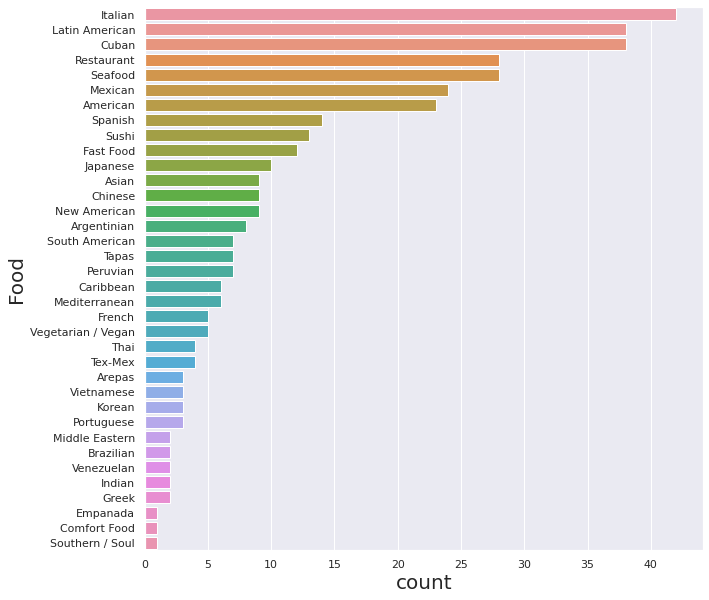

In [ ]:
sns.set(rc = {"font.size":20, "axes.titlesize":20, "axes.labelsize":20, 'figure.figsize':(10,10)})
sns.countplot(y = "Food", data = restaurants_miami, order = restaurants_miami['Food'].value_counts().index)

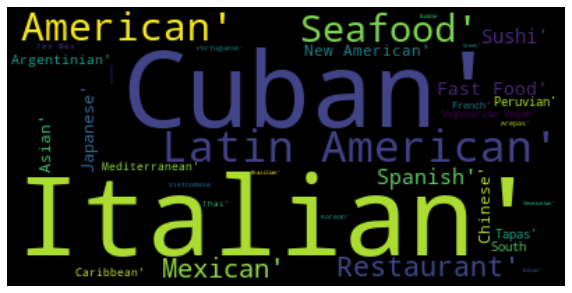

In [ ]:
text = restaurants_miami['Food'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Step 07 - Analize (Clustering)

## 07.1 - Cluster Visualization



## Question: What is the ideal cluster number?

In [ ]:
K_clusters = range(1, 20)
kmeans = [KMeans(n_clusters = i) for i in K_clusters]
Y_axis = restaurants_miami[['Latitude']]
X_axis = restaurants_miami[['Longitude']]
distances = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

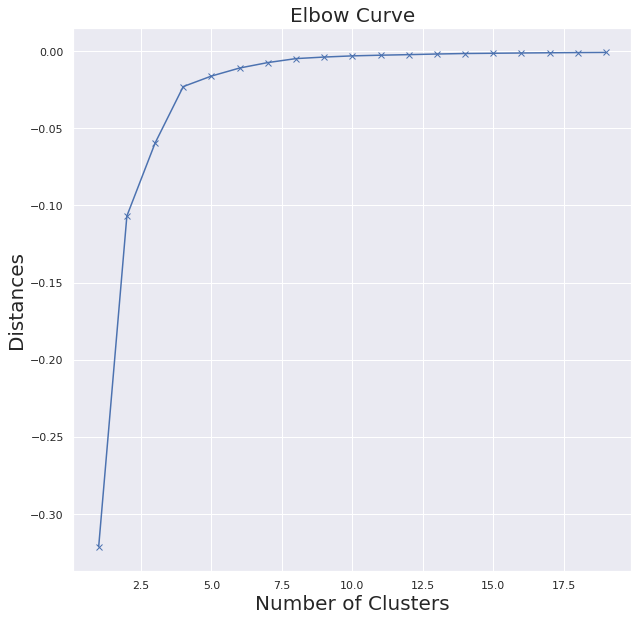

In [ ]:
# Visualize
plt.plot(K_clusters, distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distances')
plt.title('Elbow Curve')
plt.show()



> In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. In our case approximately 4.5. But I used 4.0.



In [ ]:
neighborhood_clustering = restaurants_miami[['Food','Latitude','Longitude','Neighborhood']]
kclusters = 4

kmeans = KMeans(n_clusters = kclusters, init ='k-means++')
kmeans.fit(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering['Cluster Label'] = kmeans.fit_predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Seafood,25.805638,-80.223992,Allapattah,1
1,Seafood,25.824110,-80.224870,Allapattah,1
2,Cuban,25.803466,-80.223886,Allapattah,1
3,Vegetarian / Vegan,25.801454,-80.203389,Allapattah,1
4,Asian,25.800933,-80.200203,Allapattah,1
...,...,...,...,...,...
376,Peruvian,25.760445,-80.367000,West Flagler,2
377,Latin American,25.766977,-80.368508,West Flagler,2
378,Cuban,25.785594,-80.368177,West Flagler,2
379,Chinese,25.775368,-80.368472,West Flagler,2


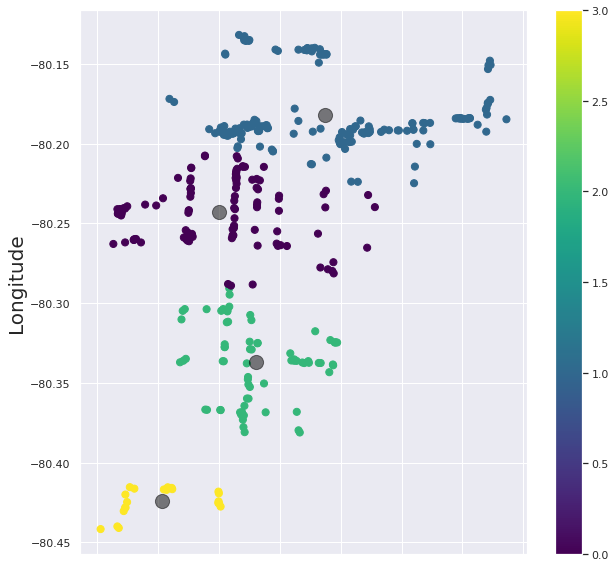

In [ ]:
neighborhood_clustering.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

In [ ]:
centers = kmeans.cluster_centers_
print(centers)

[[ 25.76013511 -80.24273237]
 [ 25.79479388 -80.18190065]
 [ 25.77234291 -80.33705784]
 [ 25.7411814  -80.42380409]]


## Mount Cluster Data

In [ ]:
neighborhood_clustering = neighborhood_clustering.sort_values(by='Cluster Label', ascending = True).reset_index(drop = True)
neighborhood_clustering

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Restaurant,25.764283,-80.259342,Grapeland Heights,0
1,Asian,25.749132,-80.254331,Coconut Grove,0
2,Mexican,25.751399,-80.258494,Coconut Grove,0
3,American,25.749200,-80.258781,Coconut Grove,0
4,Italian,25.750231,-80.261248,Coconut Grove,0
...,...,...,...,...,...
376,Restaurant,25.744523,-80.415846,Coral Way,3
377,Cuban,25.743903,-80.415879,Coral Way,3
378,Japanese,25.760099,-80.425656,Coral Way,3
379,Latin American,25.729868,-80.424732,Coral Way,3


In [ ]:
neighborhood_merged = neighborhood_clustering
neighborhood_merged = neighborhood_clustering.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
neighborhood_merged = neighborhood_merged.sort_values(by='Cluster Label', ascending = True).reset_index(drop = True)
neighborhood_merged

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Restaurant,25.764283,-80.259342,Grapeland Heights,0,Cuban,Latin American,Mexican,Tapas,Restaurant
1,Thai,25.765710,-80.223195,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
2,Cuban,25.765835,-80.225167,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
3,Seafood,25.765871,-80.221476,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
4,Latin American,25.772867,-80.228726,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
...,...,...,...,...,...,...,...,...,...,...
376,Seafood,25.759811,-80.425266,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
377,Italian,25.727143,-80.440956,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
378,Latin American,25.729868,-80.424732,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
379,Latin American,25.759923,-80.424294,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American


## Show Map - Cluster

In [ ]:
# create map
map_clusters = folium.Map(location = MIAMI_COORDINATES, tiles="cartodbpositron", zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

locations = neighborhood_merged[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

for i in range(0, len(location_list)):

    point_name = neighborhood_merged['Food'][i]
    point_yard = neighborhood_merged['Neighborhood'][i]
    point_cluster = neighborhood_merged['Cluster Label'][i]
    point_detail = '<b>' + point_name + '</b><br /><i> Cluster ' + str(point_cluster) + ' in '  + point_yard + '</i>'

    folium.CircleMarker(
        location_list[i],
        radius = 5,
        popup = point_detail,
        color = rainbow[point_cluster - 1],
        fill = True,
        fill_color = rainbow[point_cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1

In [ ]:
## Cluster 1 in neighborhood_merged
neighborhood_cluster1 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 0]
neighborhood_cluster1

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Restaurant,25.764283,-80.259342,Grapeland Heights,0,Cuban,Latin American,Mexican,Tapas,Restaurant
1,Thai,25.765710,-80.223195,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
2,Cuban,25.765835,-80.225167,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
3,Seafood,25.765871,-80.221476,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
4,Latin American,25.772867,-80.228726,Little Havana,0,Latin American,Cuban,Mexican,Spanish,Seafood
...,...,...,...,...,...,...,...,...,...,...
106,French,25.727652,-80.242798,Coconut Grove,0,Italian,American,New American,Restaurant,Latin American
107,Mediterranean,25.732022,-80.260391,Coconut Grove,0,Italian,American,New American,Restaurant,Latin American
108,Indian,25.729218,-80.240778,Coconut Grove,0,Italian,American,New American,Restaurant,Latin American
109,Italian,25.728103,-80.243848,Coconut Grove,0,Italian,American,New American,Restaurant,Latin American


## Cluster 2

In [ ]:
## Cluster 2 in neighborhood_merged
neighborhood_cluster2 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 1]
neighborhood_cluster2

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
111,South American,25.807009,-80.193055,Buena Vista,1,Italian,Restaurant,Latin American,New American,Arepas
112,Asian,25.809132,-80.193461,Buena Vista,1,Italian,Restaurant,Latin American,New American,Arepas
113,Argentinian,25.827147,-80.191837,Buena Vista,1,Italian,Restaurant,Latin American,New American,Arepas
114,Mexican,25.766791,-80.193429,Arts & Entertainment District,1,Seafood,Italian,American,Restaurant,Mexican
115,Seafood,25.770244,-80.189547,Arts & Entertainment District,1,Seafood,Italian,American,Restaurant,Mexican
...,...,...,...,...,...,...,...,...,...,...
280,Restaurant,25.790848,-80.192560,Overtown,1,Restaurant,American,Seafood,Asian,Italian
281,Seafood,25.793405,-80.190689,Overtown,1,Restaurant,American,Seafood,Asian,Italian
282,French,25.760663,-80.189943,The Roads,1,Latin American,Italian,Argentinian,French,Spanish
283,Restaurant,25.799692,-80.196110,Overtown,1,Restaurant,American,Seafood,Asian,Italian


## Cluster 3

In [ ]:
## Cluster 3 in neighborhood_merged
neighborhood_cluster3 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 2]
neighborhood_cluster3

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
285,Tex-Mex,25.784727,-80.336151,Park West,2,Latin American,Mexican,American,Sushi,Seafood
286,Seafood,25.783814,-80.335997,Park West,2,Latin American,Mexican,American,Sushi,Seafood
287,American,25.785522,-80.336233,Park West,2,Latin American,Mexican,American,Sushi,Seafood
288,Fast Food,25.769531,-80.347835,Park West,2,Latin American,Mexican,American,Sushi,Seafood
289,Italian,25.769591,-80.346332,Park West,2,Latin American,Mexican,American,Sushi,Seafood
...,...,...,...,...,...,...,...,...,...,...
354,Tex-Mex,25.770129,-80.324207,Flagami,2,Cuban,Latin American,Fast Food,Chinese,Spanish
355,Korean,25.772777,-80.325005,Flagami,2,Cuban,Latin American,Fast Food,Chinese,Spanish
356,Fast Food,25.762810,-80.305225,Flagami,2,Cuban,Latin American,Fast Food,Chinese,Spanish
357,South American,25.763426,-80.302229,Flagami,2,Cuban,Latin American,Fast Food,Chinese,Spanish


## Cluster 4

In [ ]:
## Cluster 4 in neighborhood_merged
neighborhood_cluster4 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 3]
neighborhood_cluster4

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
359,Mexican,25.730768,-80.415389,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
360,Fast Food,25.743213,-80.415472,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
361,Fast Food,25.760008,-80.419266,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
362,Spanish,25.726676,-80.439991,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
363,Cuban,25.743903,-80.415879,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
364,Restaurant,25.744523,-80.415846,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
365,Japanese,25.760099,-80.425656,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
366,Arepas,25.729249,-80.428081,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
367,Fast Food,25.721175,-80.441668,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
368,Cuban,25.732255,-80.416326,Coral Way,3,Cuban,Latin American,Fast Food,Mexican,South American
